In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import AdaBoostClassifier 
     
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import json
import os
import re

import gensim 
from gensim.models import Word2Vec
import gensim.downloader

import pickle 

import nltk
from nltk.tokenize import word_tokenize

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /homes/lgf21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
tqdm.pandas()

# Opening Files: 

In [5]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [6]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

ParserError: Error tokenizing data. C error: EOF inside string starting at row 13

In [25]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

NameError: name 'df_s' is not defined

# Merging Files: 

In [7]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tactic_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [6]:
Y_s

,TA0001,TA0002,TA0003,TA0004,TA0005,TA0006,TA0007,TA0008,TA0009,TA0010,...,TA0102,TA0103,TA0104,TA0105,TA0106,TA0107,TA0108,TA0109,TA0110,TA0111
0,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1516,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1518,0,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('TA')]]

In [10]:
Y_r

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,0,1,0,1,1,0,1,0,1,1,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,0,1,0,0,1,0,1,1,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,1,0,0,0,0,0,0,0,0
1486,0,0,0,1,0,0,0,0,0,0,0,0
1487,0,0,0,1,0,0,0,0,0,0,0,0
1488,0,0,0,1,0,0,0,0,0,0,0,0


In [9]:
Y1 = Y_s[Y_r.columns]
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the tactic in Y1

In [12]:
Y1

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,0,0,1,1,1,0,1,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,0,0
2,0,1,1,0,1,0,1,0,1,1,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1,1,0,1,1,1,1,0,1,1,1,1
1516,0,1,0,1,1,0,1,0,0,0,1,0
1517,0,0,0,0,0,0,0,0,0,0,1,0
1518,0,1,0,1,0,0,1,0,1,1,1,0


# Pre-processing: 

In [9]:
# Open Pickle: 

with open('lemma_preprocessing.pickle', 'rb') as handle:
    tac_preprocessing = pickle.load(handle)

In [134]:
np.mean(list(map(len, X_r))) # length of text - average 21,542 words 

21542.208588957055

In [135]:
nlp = spacy.load("en_core_web_sm", disable=['ner']) 

In [136]:
# Lemmatisation: 

df = pd.DataFrame({"text": X_r})
df['lemma'] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))


In [100]:
# Stemming: 

# stemmer = SnowballStemmer(language='english')
# df['stemmer'] = df['text'].apply(lambda x: " ".join([stemmer.stem(token) for token in x]))


In [138]:
# Save as pickle: 

with open('lemma_preprocessing.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Split dataset: 

In [72]:
# change x train to df['lemma'] or X_r #


X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(X_r, Y_r, test_size=0.3,
                                                    random_state = 10)

In [73]:
X_train_text = pd.concat([X_r_train, X_s])

In [74]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

# Feature Extraction:

In [75]:
def feature_extraction(featureExtract, X_train_text, X_test_text, average = False):
    if featureExtract in ['CountVectorizer', 'TfIdfVectorizer']:
        if featureExtract== 'CountVectorizer':
            fe = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 2, max_df = 0.99) # if words used less than 0.001 % --> ignore  
        else:
            fe = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df=0.99)
        
        X_train = fe.fit_transform(X_train_text)
        X_train = pd.DataFrame(X_train.toarray(), columns = fe.get_feature_names()) 
        X_test = fe.transform(X_test_text)
        X_test = pd.DataFrame(X_test.toarray(), columns = fe.get_feature_names())
    
    else:
        model = gensim.downloader.load(featureExtract)
        # sent is tokenised sentence on which we do the embedding
        def get_embeddings(sent):
            # if text not in vocab:
            words_in_vocab = [word for word in sent if word in model]
            if not words_in_vocab:
                return np.zeros_like(model['the'])
            emb = model[words_in_vocab]
            return np.mean(emb, axis=0) if average else np.sum(emb, axis=0)
        #perform tokenisation
        X_train = pd.DataFrame(X_train_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
        X_test = pd.DataFrame(X_test_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
    return X_train, X_test
        
        
        

In [279]:
X_train.shape

(2376, 48020)

In [76]:
X_train, X_test = feature_extraction('CountVectorizer', X_train_text, X_test_text)

In [49]:
#X_train, X_test = feature_extraction('TfIdfVectorizer', X_train_text, X_test_text)

In [14]:
#X_train, X_test = feature_extraction('word2vec-google-news-300', X_train_text, X_test_text)

KeyboardInterrupt: 

In [18]:
# ---------------- Word2Vec ---------------------: 

#glove = gensim.downloader.load('glove-wiki-gigaword-100')


In [ ]:
# ---------------- Glove ---------------------: 

# load the whole embedding into memory
#embeddings_index = dict()
#f = open('../data/glove/glove.6B.100d.txt')

# loop through each lines as key, values as coefficients
#for line in f:
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs 

#f.close()

#X_train = df['lemma'].apply(lambda x: [embeddings_index[word] for word in x]) 


In [216]:
X_train, X_test = feature_extraction('glove-wiki-gigaword-100', X_train_text, X_test_text)

100%|██████████| 441/441 [00:04<00:00, 88.96it/s] 


In [145]:
X_train.shape

(2376, 73887)

In [146]:
Y_train.shape

(2376, 12)

# Measuring Cosine Similarity to Remove Duplicates: 

In [77]:
similarities = cosine_similarity(X_train, X_test)

In [78]:
duplicates = set()
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            # print(i, j, similarities[i][j])
            duplicates.add(i)

In [79]:
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

In [108]:
Y_train

,TA0006,TA0002,TA0040,TA0003,TA0004,TA0008,TA0005,TA0010,TA0007,TA0009,TA0011,TA0001
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0
4,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2371,1,1,0,1,1,1,1,0,1,1,1,1
2372,0,1,0,1,1,0,1,0,0,0,1,0
2373,0,0,0,0,0,0,0,0,0,0,1,0
2374,0,1,0,1,0,0,1,0,1,1,1,0


# Visualisation:

<AxesSubplot:>

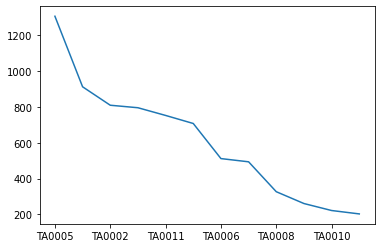

In [20]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

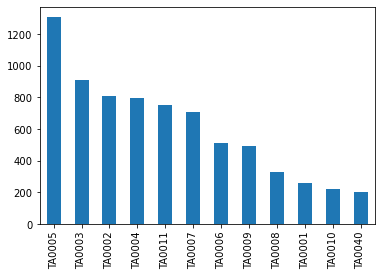

In [21]:
Y_train.sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [288]:
# TSNE using vector from glove: 

X = list(X_train.values)
X_embedded = TSNE(n_components=2).fit_transform(X)

df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label= Y_train)

ValueError: Expected a 1D array, got an array with shape (2229, 12)

In [ ]:
fig = px.scatter(
    df_embeddings, x ='tactic', y ='text',
    color='label', labels={'color': 'label'}
    hover_data=['text'], title = 'GoEmotions Embedding Visualization')
fig.show()

# Evaluation:

In [53]:
def evaluation(Y_pred, Y_test):
    macro_precision = precision_score(Y_test, Y_pred, average ='macro')
    micro_precision = precision_score(Y_test, Y_pred, average ='micro')
    macro_recall = recall_score(Y_test, Y_pred, average='macro')
    micro_recall = recall_score(Y_test, Y_pred, average='micro')
    macro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')
    micro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')
    l_metric = ['macro precision', 'micro precision', 'macro recall', 'micro recall', 'macro fscore', 'micro fscore']
    l_result = [macro_precision, micro_precision, macro_recall, micro_recall, macro_fscore, micro_fscore]
    df_res = pd.DataFrame({'metric': l_metric, 'result': l_result})
    return df_res

## Naive Bayes:

In [80]:
naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [81]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(X_test), columns = Y_test.columns)

In [82]:
y_pred = (y_pred_proba > 0.005).astype(int) # if increase threshold, recall decreases and precision (could) increase

In [83]:
evaluation(y_pred, Y_test)

,metric,result
0,macro precision,0.666805
1,micro precision,0.423497
2,macro recall,0.306688
3,micro recall,0.253475
4,macro fscore,0.382681
5,micro fscore,0.373404


## SVC:

In [92]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/liviafries/opt/anacon

OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [93]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

In [94]:
evaluation(y_pred, Y_test)

,metric,result
0,macro precision,0.666805
1,micro precision,0.423497
2,macro recall,0.306688
3,micro recall,0.253475
4,macro fscore,0.382681
5,micro fscore,0.373404


## Multi-label KNN: 

In [226]:
knn = MLkNN(k = 3)

In [227]:
# train
knn.fit(X_train.values, Y_train.values)

# predict
predictions = knn.predict(X_test.values)

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [233]:
evaluation(predictions, Y_test)

0.3973834832379395

## Logistic Regression:

In [ ]:
# reduce dimension using pca: 

pca = PCA(n_components=150)
pca.fit(X_train)
pca_result = pca.transform(X_train)
x_test_result = pca.transform(X_test )

In [290]:
X_train.shape

(2229, 8446)

In [ ]:
log_reg = OneVsRestClassifier(LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs', max_iter = 1000)).fit(X_train, Y_train)

predictions = log_reg.predict(X_test)


In [ ]:
evaluation(predictions, Y_test)

## DT AdaBoost: 

In [71]:
dt_adaboost = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train, Y_train)
predictions_ada = dt_adaboost.predict(X_test)

KeyboardInterrupt: 

In [ ]:
evaluation(predictions_ada, Y_test)

# Classifer Chain: 

In [ ]:
def chain_model(model):
    model_chain = ClassifierChain(model, order='random', random_state=0)
    return model_chain

In [89]:
#chain = chain_model(naive_bayes_classifier) # change model appropriately

In [ ]:
chain = chain_model(log_reg) # change model appropriately

In [ ]:
chainModel = chain.fit(X_train.values, Y_train.values)
predictions = chainModel.predict(X_test.values)

In [ ]:
evaluation(predictions, Y_test)